# Transforms Group

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Export

#Internal dependencies
from exp.nb_AudioCommon import * 
from exp.nb_DataAugmentation import * 

## Common Functions 

In [3]:
#Export
TfmsGroups = [TfmList]

In [4]:
#Export
def flatten(x, flattenStrings=False):
    '''Transforms [[x]] in [x]'''
    if not flattenStrings:
        if isinstance(x,str):
            return [x]
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

In [5]:
def test_flatten():
    A=[[1,2],[3,4,5]]
    assert [1,2,3,4,5] == flatten(A)
    
    B = [A]
    assert [1,2,3,4,5] == flatten(B)

    C = [[1,2],3,[4,5]]
    assert [1,2,3,4,5] == flatten(C)
    
    print('DONE')

test_flatten()

DONE


In [6]:
def test_flatten_with_string():
    A='abcd'
    assert ['abcd'] == flatten(A)

    B=['ab','cd']
    assert ['ab','cd'] == flatten(B)

    C=[['hello'],' ',['world']]
    assert ['hello',' ','world'] == flatten(C)

    print('DONE')
    
test_flatten_with_string()

DONE


In [7]:
#Export
def getTfmList(g:TfmsGroups, up_to_grpup=None)->TfmList:
    '''Returns transformations up to specified group included'''
    grps = g if up_to_grpup is None else [x for i,x in enumerate(g) if i<=up_to_grpup] 
    ret = flatten(grps)
    ret = [t for t in ret if []!=t] # filter none
    return ret

In [8]:
def test_getTfmList():
    g = [[torchaudio.transforms.Scale, torchaudio.transforms.PadTrim],[torchaudio.transforms.MEL]]
    assert 3==len(getTfmList(g))
    assert 2==len(getTfmList(g,0))
    assert 3==len(getTfmList(g,1))
    print('DONE')
    
test_getTfmList()

DONE


In [9]:
#Export
def applyTfms(tfms:TfmList, x):
    '''Apply a list of transformations'''
    ret = x
    for tfm in tfms:
        ret = tfm(ret)
    return ret

## Transformations Manager

In all the situation where there are complex transformtations (ie: an augmented sound that becomes an image), TfmsManager can help you to **group transformations into meaningful groups that can be easily tested separately**.
Once you've completed the fine tuning step of each group of transformations, **get_tfms()** consolidate your work and generates the final transform list compatible with fast.ai.

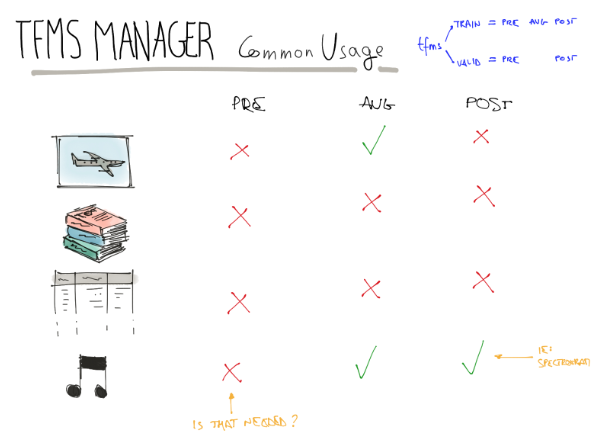

In [10]:
#Export
class TfmsManager:
    def __init__(self, train_tfms_groups:TfmsGroups, valid_tfms_groups:TfmsGroups):
        self.train_tfmsg, self.valid_tfmsg = listify(train_tfms_groups), listify(valid_tfms_groups)
    
    def get_tfms(self)->[TfmList,TfmList]:
        return [self.get_train_tfms(up_to_grpup=None), self.get_valid_tfms(up_to_grpup=None)]

#Training set functions
    def get_train_tfms(self, up_to_grpup=None)->TfmList:
        return getTfmList(self.train_tfmsg,up_to_grpup)    
        
    def apply_train_tfms(self, x, up_to_grpup=None):
        return applyTfms(self.get_train_tfms(up_to_grpup),x)
    
#Validation set functions 
    def get_valid_tfms(self, up_to_grpup=None)->TfmList:
        return getTfmList(self.valid_tfmsg,up_to_grpup)

    def apply_valid_tfms(self, x, up_to_grpup=None):
        return applyTfms(self.get_train_tfms(up_to_grpup),x)

    @classmethod
    def create_from_main_groups(cls, pre:TfmList, aug:TfmList, size:TfmList, post:TfmList):
        '''Create TfmsManager from three main components:
        + pre: pre data augmentation transforms
        + aug: data augmentation transforms
        + post: post data augmentation transforms
        
        NB: train_tfms = [pre,aug,size,post]
            valid_tfms = [pe,size,post]
        '''
        return cls([pre,aug,size,post],[pre,size,post])

**IMPORTANT**: to use TfmsManager with fast.ai use:

```python
tm = TfmsManager.create_from_main_groups(...)

tfms = tm.get_tfms() # THIS ROW ADAPT THE TRANSFORMATIONS TO fast.ai

data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch
```

## Transformations Manager: customize for Audio

In [11]:
#Export
class AudioTfmsManager(TfmsManager):
    
    def try_data_augmentation(self,ad:AudioData, lbl:str=None, showResults=True, **kwargs)->AudioData:
        '''Try to apply data augmentation only and show labels'''
        y=applyTfms(self.get_train_tfms(2),ad) # All tfms
        if showResults: self.showAudio(y,lbl,ad,**kwargs)
        return y

    def try_spectrogram(self,ad:AudioData, lbl:str=None, showResults=True, **kwargs):
        '''The valid transforms has only pre and post (spectrogram)'''
        y=applyTfms(self.get_valid_tfms(),ad) # All valid tfms - no data augmentation
        if showResults: self.showSpec(y,lbl,**kwargs)
        return y
    
    def try_train_tfms(self,ad:AudioData, lbl:str=None, showResults=True, **kwargs):
        '''Try to apply all train transforms to an audio signal'''
        yaug=self.try_data_augmentation(ad,lbl,showResults,**kwargs)
        y = applyTfms(listify(self.train_tfmsg[-1]),yaug)
        if showResults: self.showSpec(y,lbl,**kwargs)
        return y
    
    def showAudio(self, dst:AudioData, lbl, src:AudioData=None, showSound=True, showPlot=True, showSource=True, **kwargs):
        lbl = lbl or '?'
        if showSound: 
            display(f'Label: {lbl}')
            if (src is not None) and showSource: display(Audio(src.sig,rate=src.sr))
            if (dst is not None): display(Audio(dst.sig,rate=dst.sr))
        if showPlot:
            if (src is not None) and showSource: plt.plot(src.sig, 'r')
            if dst is not None: plt.plot(dst.sig, 'b')

    def showSpec(self, spec:torch.Tensor, lbl, **kwargs):
        '''Shape Should be (n_channels,hh,ww)'''
        lbl = lbl or '?'
        display(f'Label: {lbl}')
        for i in range(spec.shape[0]):
            img = spec[i,:,:].unsqueeze(0) # need to unsqueeze because Image whats 1xHxW
            display(Image(img))
            
    @classmethod
    def get_audio_tfms_manager(cls,
                             spectro:bool=False,
                             white_noise:bool=True,
                             modulate_volume:bool=True,
                             random_cutout:bool=True,
                             pad_with_silence:bool=True,
                             pitch_warp:bool=True,
                             down_and_up:bool=True,
                             mx_to_pad:int=1000,
                             xtra_pre_tfms:TfmList=None,
                             xtra_aug_tfms:TfmList=None,
                             xtra_post_tfms:TfmList=None,
                             **kwargs)->TfmsManager:
        '''factory to create audio transforms manager.'''
        pre = [] + listify(xtra_pre_tfms)
        
        aug = []
        if white_noise: aug.append(partial(tfm_add_white_noise, **kwargs))
        if modulate_volume: aug.append(partial(tfm_modulate_volume, **kwargs))
        if random_cutout: aug.append(partial(tfm_random_cutout, **kwargs))
        if pad_with_silence: aug.append(partial(tfm_pad_with_silence, **kwargs))
        if pitch_warp: aug.append(partial(tfm_pitch_warp, **kwargs))
        if down_and_up: aug.append(partial(tfm_down_and_up, **kwargs))
        aug += listify(xtra_aug_tfms)

        size = []
        if mx_to_pad: size.append(partial(tfm_pad_to_max, mx=mx_to_pad))
        
        post = []
        post += [partial(tfm_spectro, **kwargs) if spectro else partial(tfm_extract_signal, **kwargs)]
        post += listify(xtra_post_tfms)
        
        return cls.create_from_main_groups(pre,aug,size,post)

In [12]:
def test_get_audio_tfms_manager():
    tm=AudioTfmsManager.get_audio_tfms_manager()

    # fast.ai integration
    tfms = tm.get_tfms()
    print('fast.ai tfms = ',tfms)
    assert 2==len(tfms), 'tfms tuple for fast.ai'
    assert 8==len(tfms[0]), 'train transformations'
    assert 2==len(tfms[1]), 'valid transformations'
    
    assert 8==len(tm.get_train_tfms())
    assert 2==len(tm.get_valid_tfms())
    assert 7==len(tm.get_train_tfms(2)) # data augmentation -> pre+aug
    
    tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True,
                         white_noise=False,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=1000)
    assert 2==len(tm.get_train_tfms())
    assert 2==len(tm.get_valid_tfms())

    print('DONE')
    
test_get_audio_tfms_manager()

fast.ai tfms =  [[functools.partial(<function tfm_add_white_noise at 0x7f2ff374c378>), functools.partial(<function tfm_modulate_volume at 0x7f2ff374c400>), functools.partial(<function tfm_random_cutout at 0x7f2ff374c488>), functools.partial(<function tfm_pad_with_silence at 0x7f2ff374c510>), functools.partial(<function tfm_pitch_warp at 0x7f2ff374c598>), functools.partial(<function tfm_down_and_up at 0x7f2ff374c620>), functools.partial(<function tfm_pad_to_max at 0x7f2ff374c730>, mx=1000), functools.partial(<function tfm_extract_signal at 0x7f2ff374c8c8>)], [functools.partial(<function tfm_pad_to_max at 0x7f2ff374c730>, mx=1000), functools.partial(<function tfm_extract_signal at 0x7f2ff374c8c8>)]]
DONE


### SAMPLE USAGE FOR AUDIO
Pretend that you want identify who is talking in a registratio. This is a tipical classificaiton problem. A way to address this problem is taking the first 2 seconds of the original sound, converting it into a MEL spectrogram and feed a CNN to classify it as it was an image.

If you want to improve the performance and the generalization of your model, one simple way is to use data augmentation, like on images.
The problem with sound is that you need to make the data augmentation (**AUG**) on the original sound, and to understand if you're doing this correctly you need to "HEAR" (listen) and "VIEW" (plot soundwave) your augmented sound.
Moreover, once you're sure about your data augmentation, you need to tune your spectrogram (**POST**) in such way that you're preserve as much information as possible for the next steps.

TfmsManager can help you in all this steps, so you can create and test independently all the transformation groups that you need. 

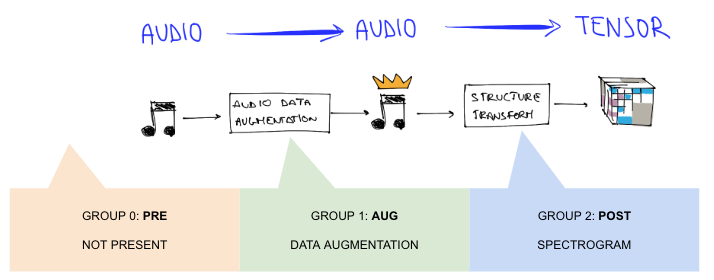

Download some test data...

In [13]:
# Download data in fast.ai format (thnx @Thom)
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
path = datapath4file('ST-AEDS-20180100_1-OS')
untar_data(data_url, dest = path)

PosixPath('/home/ste/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [14]:
sampleFile = path.ls()[4]
sampleFile

PosixPath('/home/ste/.fastai/data/ST-AEDS-20180100_1-OS/f0002_us_f0002_00263.wav')

In [15]:
sampleSound = AudioData.load(sampleFile)
display(Audio(sampleSound.sig,rate=sampleSound.sr))

### TfmsManager sample usage:
With AudioTfmsManager you can easily test separately all your transformation groups:
* DATA AUGMENTATION (AUG)
* SPECTROGRAM (POST)
<br>
<br>
Having a quick audio/visual feedback on them.

'Label: Show all'

'Label: Show all'

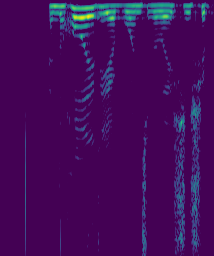

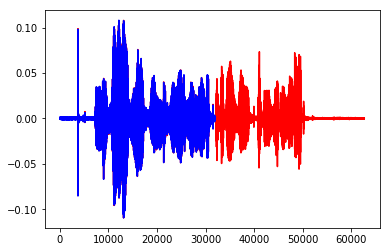

In [16]:
#Show all results
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True, n_mels=256, ws=300, n_fft=3200, to_db_scale=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)
tm.try_train_tfms(sampleSound,'Show all');

'Label: Show data augmentatio on signal only'

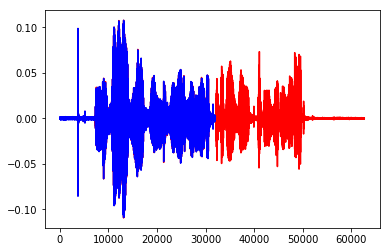

In [17]:
#Show efect of data augmentation only
tm.try_data_augmentation(sampleSound,'Show data augmentatio on signal only');

'Label: Spectrogram without data augmentation'

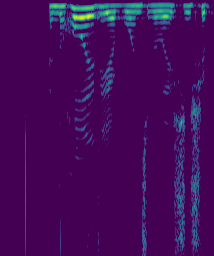

In [18]:
#Show effects of spectrogram only
tm.try_spectrogram(sampleSound,'Spectrogram without data augmentation');

### Use case: find correct parameters for data augmentation  

'Label: test'

/home/ste/anaconda3/lib/python3.7/site-packages/IPython/lib/display.py:136: RuntimeWarning: invalid value encountered in true_divide
  scaled = np.int16(data/np.max(np.abs(data))*32767).tolist()


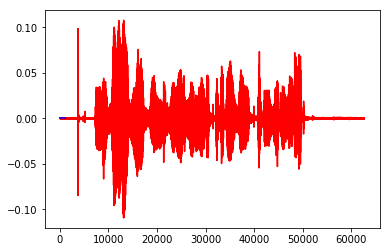

In [19]:
tm=AudioTfmsManager.get_audio_tfms_manager(spectro=True)
tm.try_data_augmentation(sampleSound,'test')

**WARNING**: these transformations completely destroy the original information...

'Label: test'

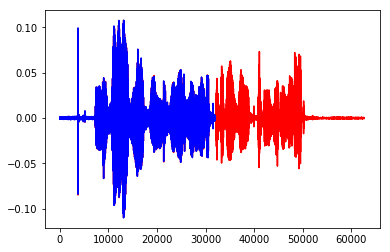

In [20]:
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)    
tm.try_data_augmentation(sampleSound,'test')

### Use case: find correct parameters for spectrogram generation  

'Label: test'

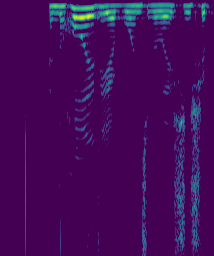

tensor([[[-80., -80., -80.,  ..., -80., -80., -80.],
         [-80., -80., -80.,  ..., -80., -80., -80.],
         [-80., -80., -80.,  ..., -80., -80., -80.],
         ...,
         [-80., -80., -80.,  ..., -80., -80., -80.],
         [-80., -80., -80.,  ..., -80., -80., -80.],
         [-80., -80., -80.,  ..., -80., -80., -80.]]])

In [21]:
tm=AudioTfmsManager.get_audio_tfms_manager(
                         spectro=True, n_mels=256, ws=300, n_fft=3200, to_db_scale=True,
                         white_noise=True, noise_scl=.00052,
                         modulate_volume=False,
                         random_cutout=False,
                         pad_with_silence=False,
                         pitch_warp=False,
                         down_and_up=False,
                         mx_to_pad=32000)    
tm.try_spectrogram(sampleSound,'test')

# Export

In [22]:
!python notebook2script.py TransformsManager.ipynb

Converted TransformsManager.ipynb to nb_TransformsManager.py
